# 1. Environment Settings

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import packages
import os
import numpy as np
import torch
import cv2
import torchvision

from torchvision import transforms
import torchvision.models as models
import torch.utils.data as D
import torch.nn as nn
import torch.optim as optim
# from skimage import io, transform
from PIL import Image

# visualization
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt 

# path
path_root = '/content/drive/Shareddrives/datathon'

# 2. EDA

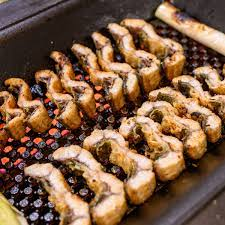

225
225
225
225


In [4]:
# preprocessing in test set
path_testdata = os.path.join(path_root, 'predict', 'test_dataset')
test_imgname = sorted(os.listdir(path_testdata))
hash_test = test_imgname.pop(0)

# EDA 
widths, heights = [], []
for img_name in test_imgname:
  img_name = os.path.join(path_testdata, img_name)
  img = cv2.imread(img_name)
  widths.append(img.shape[0])
  heights.append(img.shape[1])
  cv2_imshow(img)
  break

# plt.hist(widths)
# plt.show()
# plt.clf()

# plt.hist(heights)
# plt.show()
# plt.clf()

print(min(widths))
print(max(widths))
print(min(heights))
print(max(heights))

# 3. Data Preprocessing

In [5]:
# preprocessing
def get_file_name(root_dir, train):
    if train:
        # root_dir : './dataset'
        file_name = []
        for c1 in os.listdir(root_dir):
            for c2 in os.listdir(os.path.join(root_dir, c1)):
                file_name.extend([os.path.join(c1, c2, name) for name in (os.listdir(os.path.join(root_dir, c1, c2))) if not (name.endswith('.properties') or name.endswith('.csv'))])
        
        return file_name

    else:
        # root_dir : './predict/test_dataset'
        file_name = sorted(os.listdir(root_dir))
        file_name.pop(0)
        return file_name

def get_label_dict():
    path_root = '/content/drive/Shareddrives/datathon'
    labels = []
    for c1 in sorted(os.listdir(os.path.join(path_root, 'dataset'))):
        labels.extend(sorted([c for c in os.listdir(os.path.join(path_root, 'dataset', c1))]))
    return {label:idx for idx, label in enumerate(sorted(labels))}

# Dataset
class KoreanFood(D.Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.file_name = get_file_name(root_dir, train)
        self.transform = transform
        self.train = train
        self.label_dict = get_label_dict()

    def __len__(self):
        return len(self.file_name)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.file_name[idx])
        img = Image.open(img_name).convert("RGB")
        
        if self.transform:
            img = self.transform(img)

        if self.train:
            label = self.file_name[idx].split('/')[1]
            label = torch.tensor(self.label_dict[label])
            input = {'image':img, 'label':label}
            return input

        else:
            input = {'image':img}
            return input
            
    def print_filename(self):
        print(self.file_name)

# Data Argumentation
class CenterScaling(object):
    def __call__(self, img):
        h, w = img.size
        if h > w:
            left, upper, right, lower = 0, (h-w)/2, w, (h+w)/2 
        else:
            left, upper, right, lower = (w-h)/2, 0, (h+w)/2, h
        img_crop = img.crop((left, upper, right, lower))
        return img_crop.resize((224,224))



In [6]:
# # train, test file names

# train_file_name = get_file_name(root_dir= os.path.join(path_root, 'dataset'), train=True)
# test_file_name = get_file_name(root_dir= os.path.join(path_root, 'predict', 'test_dataset'), train=False)
# print(len(train_file_name))
# print(len(test_file_name))

print(get_label_dict())

{'가지볶음': 0, '간장게장': 1, '갈비구이': 2, '갈비찜': 3, '갈비탕': 4, '갈치구이': 5, '갈치조림': 6, '감자전': 7, '감자조림': 8, '감자채볶음': 9, '감자탕': 10, '갓김치': 11, '건새우볶음': 12, '경단': 13, '계란국': 14, '계란말이': 15, '계란찜': 16, '계란후라이': 17, '고등어구이': 18, '고등어조림': 19, '고사리나물': 20, '고추장진미채볶음': 21, '고추튀김': 22, '곰탕_설렁탕': 23, '곱창구이': 24, '곱창전골': 25, '과메기': 26, '김밥': 27, '김치볶음밥': 28, '김치전': 29, '김치찌개': 30, '김치찜': 31, '깍두기': 32, '깻잎장아찌': 33, '꼬막찜': 34, '꽁치조림': 35, '꽈리고추무침': 36, '꿀떡': 37, '나박김치': 38, '누룽지': 39, '닭갈비': 40, '닭계장': 41, '닭볶음탕': 42, '더덕구이': 43, '도라지무침': 44, '도토리묵': 45, '동그랑땡': 46, '동태찌개': 47, '된장찌개': 48, '두부김치': 49, '두부조림': 50, '땅콩조림': 51, '떡갈비': 52, '떡국_만두국': 53, '떡꼬치': 54, '떡볶이': 55, '라면': 56, 

In [7]:
# train, validation set split
transform = transforms.Compose([
    # CenterScaling(),
    transforms.Resize((224,224)),
    transforms.RandomVerticalFlip(p=.5),
    transforms.RandomHorizontalFlip(p=.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

val_ratio = .05
dataset = KoreanFood(root_dir = os.path.join(path_root, 'dataset'), transform = transform, train = True)
train_dataset, val_dataset = D.dataset.random_split(dataset, [len(dataset)-int(len(dataset)*val_ratio), int(len(dataset)*val_ratio)])
test_dataset = KoreanFood(root_dir = os.path.join(path_root, 'predict', 'test_dataset'), transform = transform, train = False)

In [8]:
# hyper parameters 
batch_size = 16
num_workers = 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
# Dataloader
train_loader = D.DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=True)
val_loader = D.DataLoader(dataset=val_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=True)
test_loader = D.DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


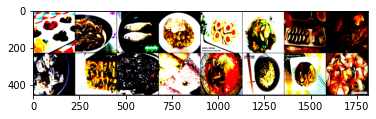

tensor([ 13,  75, 121,  17,  15,  96,  27, 126,  59,  50, 125, 141, 103,  89,
         96,  38])


In [10]:
def imshow(img):
  plt.imshow(np.transpose(img.numpy(), (1,2,0)))
  plt.show()

dataiter = iter(train_loader)
input = dataiter.next()
imshow(torchvision.utils.make_grid(input['image']))
print(input['label'])

# 4. Model Training (vgg16)

In [11]:
# model
model = models.vgg16(pretrained=True).to(device)
path_model_save = os.path.join(path_root, 'model')

# loss & optimizer
learning_rate = .001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epochs = 30
data_len = 150000

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [12]:
# training
best_acc = 0
best_model = model

for epoch in range(1, epochs + 1):
    model.train()
    for idx, input in enumerate(train_loader):
        images = input['image'].to(device)
        labels = input['label'].to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx%10 == 9:
            print("Progress:",idx,"/",data_len/batch_size, "Loss:",loss.item())

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, epochs, loss.item()))
    # if epoch % 10 == 0:
    #   torch.save(model.state_dict(), model_weight_save_path + 'model_' + str(epoch) + ".pth")
    torch.save(model.state_dict(), os.path.join(path_model_save, 'vgg16__'+str(epoch)+'.pth'))

    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        for input in val_loader:
            images = input['image'].to(device)
            labels = input['label'].to(device)
         
           # Forward pass
            outputs = model(images)
            _, pred = torch.max(outputs.data, 1)
            total += len(labels)
            correct += (pred == labels).sum().item()
            
        acc = correct/total
        print('Epoch [{}/{}], Accuracy(validation set, {} images): {} %'.format(epoch, epochs, total))

    if acc > best_acc:
        best_acc = acc
        best_model = model

    torch.save(model.state_dict(), os.path.join(path_model_save, 'vgg16_'+str(epoch)+'.pth'))

# save best model
torch.save(model.state_dict(), os.path.join(path_model_save, 'vgg16.pth'))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Progress: 9 / 9375.0 Loss: 6.16726016998291
Progress: 19 / 9375.0 Loss: 5.3783860206604


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Progress: 29 / 9375.0 Loss: 5.922706604003906
Progress: 39 / 9375.0 Loss: 5.857229232788086
Progress: 49 / 9375.0 Loss: 5.5460028648376465
Progress: 59 / 9375.0 Loss: 5.521073818206787
Progress: 69 / 9375.0 Loss: 5.409026622772217
Progress: 79 / 9375.0 Loss: 4.860779285430908
Progress: 89 / 9375.0 Loss: 5.404224872589111
Progress: 99 / 9375.0 Loss: 5.240898132324219
Progress: 109 / 9375.0 Loss: 5.026382923126221
Progress: 119 / 9375.0 Loss: 5.129973888397217
Progress: 129 / 9375.0 Loss: 5.254398345947266
Progress: 139 / 9375.0 Loss: 5.094536781311035
Progress: 149 / 9375.0 Loss: 5.022995471954346
Progress: 159 / 9375.0 Loss: 5.232542514801025
Progress: 169 / 9375.0 Loss: 5.144713878631592
Progress: 179 / 9375.0 Loss: 5.029194355010986
Progress: 189 / 9375.0 Loss: 4.9441986083984375
Progress: 199 / 9375.0 Loss: 4.96489953994751
Progress: 209 / 9375.0 Loss: 5.201907634735107
Progress: 219 / 9375.0 Loss: 5.0840678215026855


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Progress: 229 / 9375.0 Loss: 5.035171031951904
Progress: 239 / 9375.0 Loss: 5.266172409057617
Progress: 249 / 9375.0 Loss: 5.089197158813477
Progress: 259 / 9375.0 Loss: 5.141684055328369
Progress: 269 / 9375.0 Loss: 4.976787567138672
Progress: 279 / 9375.0 Loss: 5.126674175262451
Progress: 289 / 9375.0 Loss: 5.054931163787842
Progress: 299 / 9375.0 Loss: 5.044755935668945
Progress: 309 / 9375.0 Loss: 4.988459587097168
Progress: 319 / 9375.0 Loss: 5.181268215179443
Progress: 329 / 9375.0 Loss: 4.944953918457031


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1498 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Progress: 339 / 9375.0 Loss: 5.108426570892334
Progress: 349 / 9375.0 Loss: 5.112612724304199
Progress: 359 / 9375.0 Loss: 4.981987953186035
Progress: 369 / 9375.0 Loss: 5.030482292175293
Progress: 379 / 9375.0 Loss: 4.978870868682861
Progress: 389 / 9375.0 Loss: 5.066457271575928
Progress: 399 / 9375.0 Loss: 5.123304843902588
Progress: 409 / 9375.0 Loss: 5.127597332000732
Progress: 419 / 9375.0 Loss: 5.176392078399658
Progress: 429 / 9375.0 Loss: 5.085626602172852
Progress: 439 / 9375.0 Loss: 5.116890907287598
Progress: 449 / 9375.0 Loss: 5.050584316253662


KeyboardInterrupt: ignored

In [ ]:
# inference

model.eval()

with torch.no_grad():
    for input in test_loader:
        images = input['image'].to(device)

        outputs = model(images)
        _, pred = torch.max(outputs, 1)

        break

In [ ]:
labels_dict = get_label_dict()
print(len(labels_dict))


# 5. Model Training (ViT)

### Reference: [vit-pytorch](https://github.com/lucidrains/vit-pytorch) (MIT License)

In [ ]:
!pip install vit-pytorch